# 1. Importing Library and Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import copy
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

<a id='1.2'></a>
# 2. Loading the Data

In [3]:
## load dataset
dataset = pd.read_excel('SCFP2009panel.xlsx')

In [4]:
#Disable warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
type(dataset)

pandas.core.frame.DataFrame

In [6]:
dataset.shape

(19285, 515)

<a id='2'></a>
# 3. Data Preparation and Feature Selection

## 3.1 Obtaining Predicted Variable

In [7]:
## Average SP500 during 2007 and 2009
Avg_SP500_2007 = 1478
Avg_SP500_2009 = 948

## Risk Tolerance in 2007
dataset['RF07']= dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['R07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07']
dataset['RT07'] = dataset['R07']/(dataset['R07']+dataset['RF07'])

# Risk Tolerance 2009
dataset['RF09']= dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['R09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09']
dataset['RT09'] = dataset['R09']/(dataset['R09']+dataset['RF09'])*\
                (Avg_SP500_2009/Avg_SP500_2007)

# R = Risky, RF = Risk Free

In [8]:
dataset_2 = copy.deepcopy(dataset)

In [9]:
## Creating the Percentage Change in Risk Tolerance between 2007 and 2009
dataset_2['PercentChange'] = np.abs(dataset_2['RT09']/dataset_2['RT07']-1)

## 3.2 Checking for NULL Values

In [10]:
## Checking for any null values and removing the null values'''
print('Null Values =',dataset_2.isnull().values.any())

Null Values = True


In [11]:
# Drop the rows containing NA
dataset_2=dataset_2.dropna(axis=0)
dataset_2=dataset_2[~dataset_2.isin([np.nan, np.inf, -np.inf]).any(1)]

TypeError: DataFrame.any() takes 1 positional argument but 2 were given

## 3.3 Making the plot for Risk Tolerance

<Axes: xlabel='RT07'>

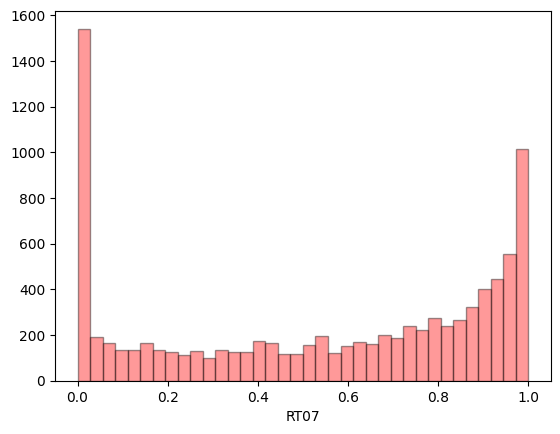

In [12]:
sns.distplot(dataset_2['RT07'], hist=True, kde=False,
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})

<Axes: xlabel='RT09'>

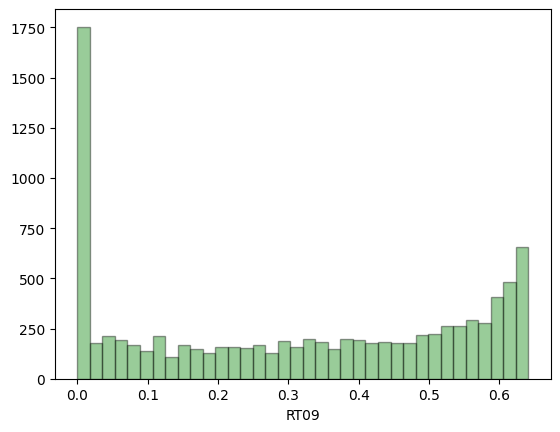

In [13]:
sns.distplot(dataset_2['RT09'], hist=True, kde=False,
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})

## 3.4 Making the True Risk Tolerance value

In [14]:
dataset_3 = copy.deepcopy(dataset_2)

In [15]:
dataset_3 = dataset_3[dataset_3['PercentChange']<=.1]

In [16]:
dataset_3['TrueRiskTolerance'] = (dataset_3['RT07'] + dataset_3['RT09'])/2

In [17]:
# Drop Labels that are not used
dataset_3.drop(labels=['RT07', 'RT09'], axis=1, inplace=True)
dataset_3.drop(labels=['PercentChange'], axis=1, inplace=True)

<a id='2.2'></a>
## 3.5 Feature Selection-Limit

In [18]:
keep_list = ['AGE07','EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07','RISK07','NETWORTH07','TrueRiskTolerance']

drop_list = [col for col in dataset_3.columns if col not in keep_list]

dataset_3.drop(labels=drop_list, axis=1, inplace=True)

In [19]:
dataset_3.head()

,AGE07,EDCL07,MARRIED07,KIDS07,OCCAT107,INCOME07,RISK07,NETWORTH07,TrueRiskTolerance
60,77,2,1,0,3,3.141680e+04,4,2.152490e+05,0.199511
425,55,4,1,1,2,2.779588e+06,2,4.964759e+07,0.641458
1122,85,4,1,0,2,3.727417e+05,4,5.837768e+07,0.589943
1190,40,2,1,3,1,5.324882e+04,3,2.688929e+05,0.434127
1228,70,2,1,0,2,3.716767e+04,3,2.015066e+06,0.228218


## 3.6 Correlation Plot to Check for Correlation

<Axes: title={'center': 'Correlation Matrix'}>

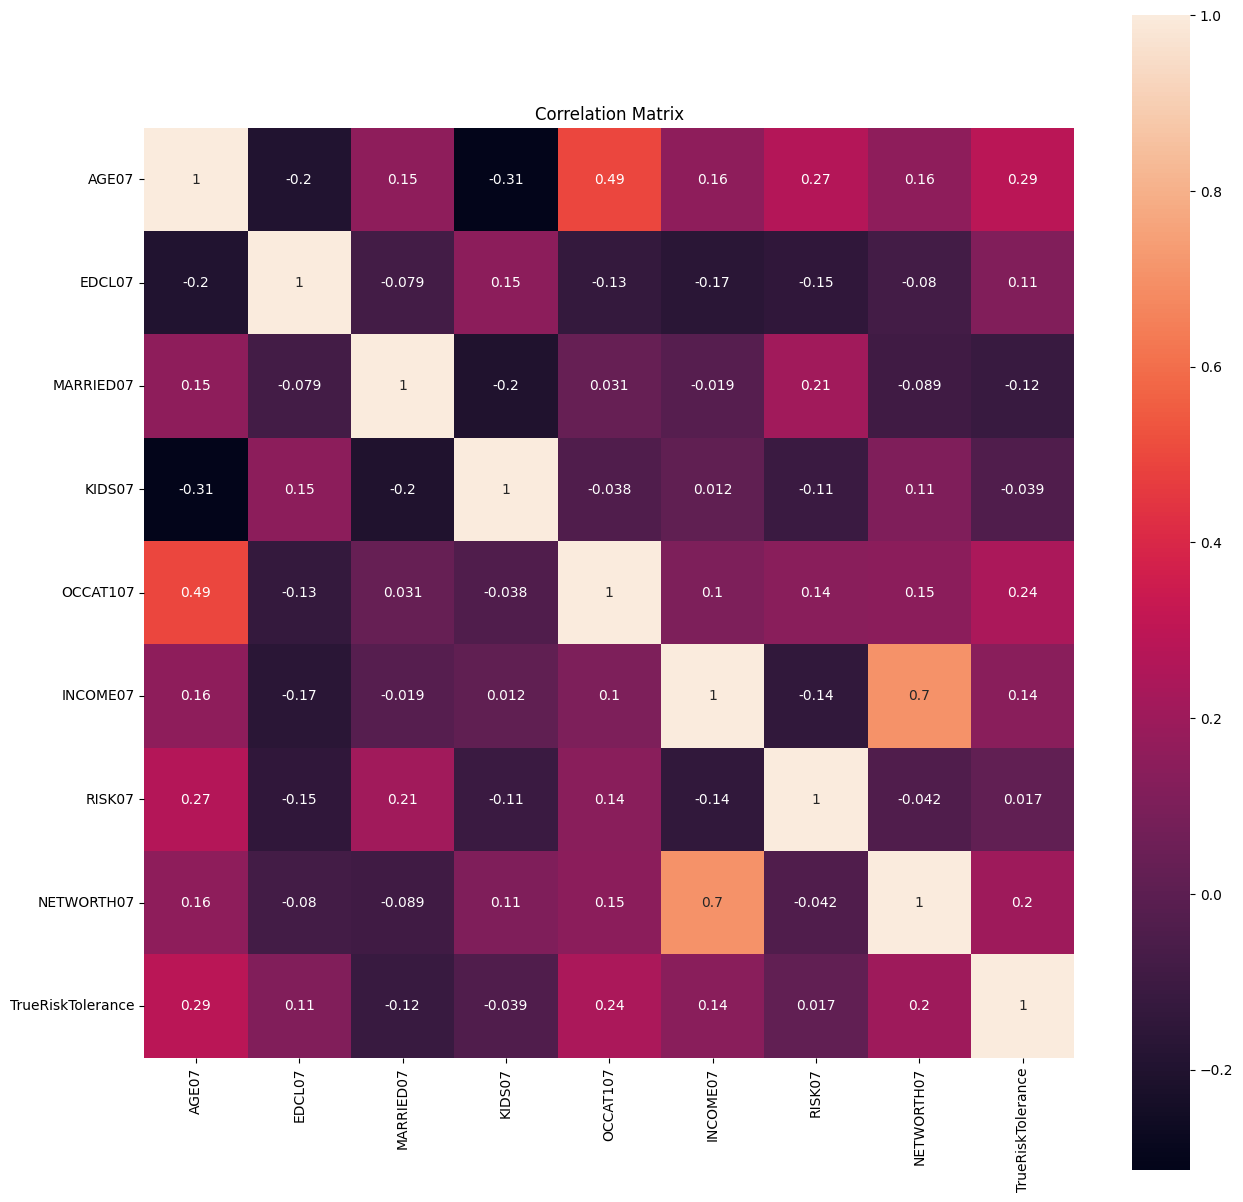

In [20]:
## Correlation using Corr Plot
correlation = dataset_3.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True)

In [21]:
dataset_3.describe()

,AGE07,EDCL07,MARRIED07,KIDS07,OCCAT107,INCOME07,RISK07,NETWORTH07,TrueRiskTolerance
count,355.000000,355.000000,355.000000,355.000000,355.000000,3.550000e+02,355.000000,3.550000e+02,355.000000
mean,53.047887,3.664789,1.200000,0.912676,1.630986,3.097267e+06,2.695775,2.010957e+07,0.402259
std,14.270806,0.734751,0.400565,1.284735,0.722244,1.383483e+07,0.779584,6.588316e+07,0.181977
min,20.000000,1.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,-6.182000e+04,0.001832
25%,43.500000,4.000000,1.000000,0.000000,1.000000,7.987322e+04,2.000000,4.291517e+05,0.274706
50%,50.000000,4.000000,1.000000,0.000000,1.000000,2.204501e+05,3.000000,1.682121e+06,0.422015
75%,61.000000,4.000000,1.000000,2.000000,2.000000,7.188590e+05,3.000000,9.905492e+06,0.561649
max,89.000000,4.000000,2.000000,5.000000,4.000000,1.170707e+08,4.000000,9.301510e+08,0.671853


<a id='4'></a>
# 4. Evaluate Algorithms and Models

<a id='4.1'></a>
## 4.1. Train and Test Data Split

In [22]:
# split out validation dataset for the end
y = dataset_3["TrueRiskTolerance"]
x = dataset_3.loc[:, dataset_3.columns != 'TrueRiskTolerance']

validation_size = 0.2
seed = 3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=validation_size, random_state=seed, shuffle = True)

<a id='4.2'></a>
## 4.2. Test Options and Evaluation Metrics


In [23]:
# test options for regression
num_folds = 10
#scoring = 'neg_mean_squared_error'
#scoring ='neg_mean_absolute_error'
scoring = 'r2'

<a id='4.3'></a>
## 4.3. Compare Models and Algorithms

In [24]:
## Creating Models used
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('RFR', RandomForestRegressor()))

In [25]:
## K-folds cross validation
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle = True, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.102704 (0.179297)
KNN: -0.424599 (0.141428)
RFR: -0.699975 (0.101472)


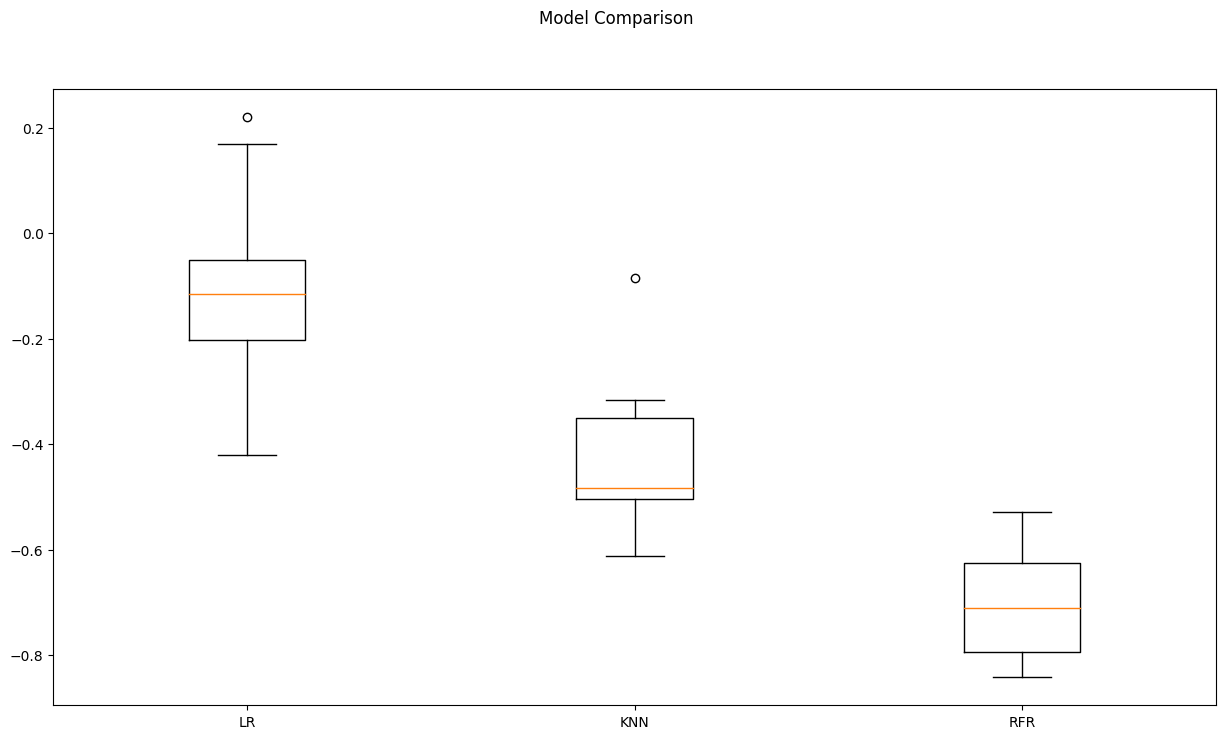

In [26]:
## compare the models
fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

<a id='5'></a>
# 5. Model Tuning and Grid Search

In [27]:
## We Use Grid Search as the method to obtain the best parameter for our model

param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle = True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
result = grid.fit(x_train, y_train)
print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.712262 using {'n_estimators': 150}
0.691089 (0.108688) with: {'n_estimators': 50}
0.708503 (0.097957) with: {'n_estimators': 100}
0.712262 (0.097145) with: {'n_estimators': 150}
0.709794 (0.102764) with: {'n_estimators': 200}
0.699791 (0.106278) with: {'n_estimators': 250}
0.709383 (0.108086) with: {'n_estimators': 300}
0.710209 (0.105271) with: {'n_estimators': 350}
0.709281 (0.103819) with: {'n_estimators': 400}


<a id='6'></a>
# 6. Finalise the Model

<a id='6.1'></a>
## 6.1. Results on the Test Dataset

In [28]:
## Prepare the model with best parameter
model = RandomForestRegressor(n_estimators = 400)
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=400)

In [29]:
from sklearn.metrics import r2_score
y_pred = model.predict(x_train)
print(r2_score(y_train, y_pred))

0.9625443979714055


In [30]:
# estimate accuracy on validation set
# transform the validation dataset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

y_pred = model.predict(x_test)
print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

0.007400940807522228
0.7731258591646879


From the mean square error and R2 shown above for the test set, the results look good.

<a id='6.2'></a>
## 6.2. Feature Importance and Features Intuition

Looking at the details above Random forest be worthy of further study.
Let us look into the Feature Importance of the RF model

[0.22596946 0.02452657 0.01297495 0.04024534 0.02494567 0.24395378
 0.04962444 0.37775979]


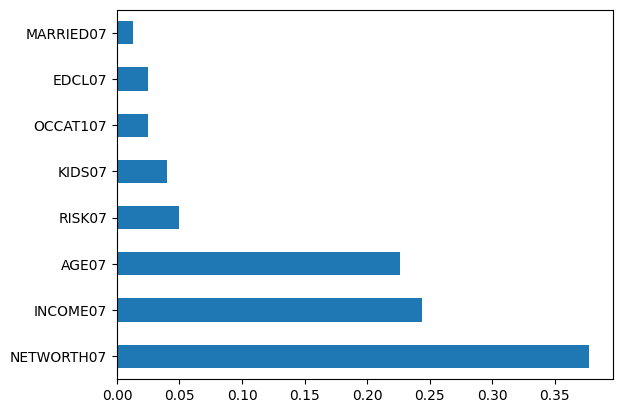

In [33]:
import pandas as pd
import numpy as np
model = RandomForestRegressor(n_estimators= 200,n_jobs=-1)
model.fit(x_train,y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

From the chart above, income and networth followed by age and willingness to take risk are the key variables to decide the risk tolerance. These variables have been considered as the key variables to model the risk tolerance across several literature.

<a id='6.3'></a>
## 6.3. Save Model for Later Use

In [34]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

In [ ]:
# load the model from disk
loaded_model = load(open(filename, 'rb'))
# estimate accuracy on validation set
pred = loaded_model.predict(x_test)
result = mean_squared_error(y_test, pred)
print(r2_score(y_test, pred))
print(result)

__Conclusion__:

We showed that machine learning models might be able to objectively
analyze the behavior of different investors in a changing market and attribute these
changes to variables involved in determining risk appetite. With an increase in the
volume of investor’s data and availability of rich machine learning infrastructure,
such models might prove to be more useful.

We saw that there is a non-linear relationship between the variables and the risk tolerance. Income and net worth followed by age and willingness to take risk are the key variables to decide the risk tolerance. These variables have been considered as the key variables to model the risk tolerance across several literature.
